In [16]:
import pandas as pd
from surprise import SVD, SVDpp, NMF, KNNBasic, KNNWithMeans, BaselineOnly
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
# The main culprit was that numpy was not imported
# it's an issue with the dill package when loading the model,
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# user_path = "../yelp_dataset/yelp_users_with_taste_profile.csv"
# rest_path = "../yelp_dataset/yelp_restaurants_filtered_with_new_features.csv"
reviews_path = "../yelp_data/yelp_restaurant_reviews_with_vader.csv"

# load reviews
rdf = pd.read_csv(reviews_path)

In [4]:
# business_df = pd.read_csv(rest_path)
# user_df = pd.read_csv(user_path)
# data filtering and reprocessing
print("Filtering data for quality recommendations...")
# count reviews per user and business
user_review_counts = rdf['user_id'].value_counts()
business_review_counts = rdf['business_id'].value_counts()

print(f"\nBefore filtering:")
print(f"Users: {rdf['user_id'].nunique():,}")
print(f"Businesses: {rdf['business_id'].nunique():,}")
print(f"Reviews: {len(rdf):,}")

# filter users with at least 30 reviews
active_users = user_review_counts[user_review_counts >= 30].index
filtered_reviews = rdf[rdf['user_id'].isin(active_users)]

Filtering data for quality recommendations...

Before filtering:
Users: 1,455,925
Businesses: 59,248
Reviews: 4,881,649


In [5]:
# filter businesses with at least 50 reviews
popular_businesses = business_review_counts[business_review_counts >= 50].index
filtered_reviews = filtered_reviews[filtered_reviews['business_id'].isin(popular_businesses)]
print(f"\nAfter filtering (>=20 reviews each):")
print(f"Users: {filtered_reviews['user_id'].nunique():,}")
print(f"Businesses: {filtered_reviews['business_id'].nunique():,}")
print(f"Reviews: {len(filtered_reviews):,}")
print(
    f"Sparsity: {1 - (len(filtered_reviews) / (filtered_reviews['user_id'].nunique() * filtered_reviews['business_id'].nunique())):.4f}")
# create working dataset with essential columns
reviews_clean = filtered_reviews[['user_id', 'business_id', 'stars', 'text', 'date']].copy()

# convert date if needed
if 'date' in reviews_clean.columns:
    reviews_clean['date'] = pd.to_datetime(reviews_clean['date'], errors='coerce')


# create surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_clean[['user_id', 'business_id', 'stars']], reader)

# 80/20 split
trainset, testset = train_test_split(data, test_size=0.2, random_state=23)


After filtering (>=20 reviews each):
Users: 18,124
Businesses: 21,967
Reviews: 1,032,884
Sparsity: 0.9974


In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(predictions):
    """
    Comprehensive evaluation metrics matching your hybrid model evaluation
    """
    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]

    # basic metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # precision@k and recall@k
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = []
        recalls = []

        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
            recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)

        return np.mean(precisions), np.mean(recalls)

    result_dict = {
        'RMSE': rmse, 'MAE': mae,
        'Precision@5': None, 'Recall@5': None,
        'Precision@10': None, 'Recall@10': None,
        'Precision@20': None, 'Recall@20': None,
        'Precision@30': None, 'Recall@30': None,
        'Precision@50': None, 'Recall@50': None,}

    for k in [5, 10, 20, 30, 50]:
        precision, recall = precision_recall_at_k(predictions, k=k)
        result_dict[f'Precision@{k}'] = precision
        result_dict[f'Recall@{k}'] = recall

    return result_dict



In [7]:
def train_and_evaluate_model(model, trainset, testset, model_name):
    """
    Train a model and evaluate it with comprehensive metrics
    """
    print(f"\n{'='*70}")
    print(f"Training {model_name}...")
    print(f"{'='*70}")
    # train
    model.fit(trainset)
    # get preds
    predictions = model.test(testset)
    results = evaluate_model(predictions)

    # show results
    print(f"\n{model_name} Results:")
    print(f"  RMSE: {results['RMSE']:.4f}")
    print(f"  MAE: {results['MAE']:.4f}")
    for k in [5, 10, 20, 30, 50]:
        print(f"  Precision@{k}: {results[f'Precision@{k}']:.4f} | Recall@{k}: {results[f'Recall@{k}']:.4f}")

    return results, predictions

In [8]:
# dictionary to store all results
all_results = {}
all_predictions = {}

# 1. SVD singular value decomposition basic matrix factorization
print("\n1. Standard SVD")
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=23)
svd_results, svd_preds = train_and_evaluate_model(svd, trainset, testset, "SVD")
all_results['SVD'] = svd_results
all_predictions['SVD'] = svd_preds




1. Standard SVD

Training SVD...

SVD Results:
  RMSE: 0.9728
  MAE: 0.7547
  Precision@5: 0.7755 | Recall@5: 0.5655
  Precision@10: 0.7533 | Recall@10: 0.7363
  Precision@20: 0.7439 | Recall@20: 0.8009
  Precision@30: 0.7419 | Recall@30: 0.8125
  Precision@50: 0.7411 | Recall@50: 0.8172


In [9]:
# 2. SVD++ (SVD with implicit feedback)
print("\n2. SVD++")
svdpp = SVDpp(n_factors=50, n_epochs=20, lr_all=0.007, reg_all=0.02, random_state=23)
svdpp_results, svdpp_preds = train_and_evaluate_model(svdpp, trainset, testset, "SVD++")
all_results['SVD++'] = svdpp_results
all_predictions['SVD++'] = svdpp_preds


2. SVD++

Training SVD++...

SVD++ Results:
  RMSE: 0.9838
  MAE: 0.7599
  Precision@5: 0.7747 | Recall@5: 0.5625
  Precision@10: 0.7544 | Recall@10: 0.7303
  Precision@20: 0.7461 | Recall@20: 0.7930
  Precision@30: 0.7444 | Recall@30: 0.8039
  Precision@50: 0.7437 | Recall@50: 0.8082


In [10]:
# 3. non-negative matrix factorization)
print("\n3. NMF")
nmf = NMF(n_factors=50, n_epochs=50, random_state=23)
nmf_results, nmf_preds = train_and_evaluate_model(nmf, trainset, testset, "NMF")
all_results['NMF'] = nmf_results
all_predictions['NMF'] = nmf_preds


3. NMF

Training NMF...

NMF Results:
  RMSE: 1.0870
  MAE: 0.7811
  Precision@5: 0.7714 | Recall@5: 0.5964
  Precision@10: 0.7466 | Recall@10: 0.7934
  Precision@20: 0.7349 | Recall@20: 0.8713
  Precision@30: 0.7322 | Recall@30: 0.8865
  Precision@50: 0.7308 | Recall@50: 0.8931


In [11]:
# 4. KNN with means
print("\n4. KNN with means")
knn_means = KNNWithMeans(k=40, sim_options={'name': 'pearson', 'user_based': True})
knn_results, knn_preds = train_and_evaluate_model(knn_means, trainset, testset, "KNN with Means")
all_results['KNN with Means'] = knn_results
all_predictions['KNN with Means'] = knn_preds




4. KNN with means

Training KNN with Means...
Computing the pearson similarity matrix...
Done computing similarity matrix.

KNN with Means Results:
  RMSE: 1.0305
  MAE: 0.7858
  Precision@5: 0.7591 | Recall@5: 0.5372
  Precision@10: 0.7429 | Recall@10: 0.6956
  Precision@20: 0.7356 | Recall@20: 0.7547
  Precision@30: 0.7340 | Recall@30: 0.7655
  Precision@50: 0.7333 | Recall@50: 0.7699

5. Baseline

Training Baseline...
Estimating biases using als...

Baseline Results:
  RMSE: 0.9730
  MAE: 0.7603
  Precision@5: 0.7812 | Recall@5: 0.5887
  Precision@10: 0.7556 | Recall@10: 0.7710
  Precision@20: 0.7448 | Recall@20: 0.8401
  Precision@30: 0.7424 | Recall@30: 0.8527
  Precision@50: 0.7414 | Recall@50: 0.8580


In [14]:
# 5. baseline (using ALS for optimization) alternating least squares
print("\n5. Baseline")
baseline = BaselineOnly(bsl_options={'method': 'als', 'n_epochs': 20})
baseline_results, baseline_preds = train_and_evaluate_model(baseline, trainset, testset, "Baseline")
all_results['Baseline'] = baseline_results
all_predictions['Baseline'] = baseline_preds


5. Baseline

Training Baseline...
Estimating biases using als...

Baseline Results:
  RMSE: 0.9730
  MAE: 0.7603
  Precision@5: 0.7812 | Recall@5: 0.5887
  Precision@10: 0.7556 | Recall@10: 0.7710
  Precision@20: 0.7448 | Recall@20: 0.8401
  Precision@30: 0.7424 | Recall@30: 0.8527
  Precision@50: 0.7414 | Recall@50: 0.8580


In [15]:
# model reults from hybrid model for comparison (from final model notebook)

hybrid = {'RMSE': 0.9869361944261617,
 'MAE': 0.7723092600681472,
 'Precision@5': 0.7774316879479668,
 'Recall@5': 0.6013302408225407,
 'Precision@10': 0.749883152457637,
 'Recall@10': 0.7937925924053102,
 'Precision@20': 0.7387672435752058,
 'Recall@20': 0.8666156224397269,
 'Precision@30': 0.736213513976508,
 'Recall@30': 0.8798721035208513,
 'Precision@50': 0.7351440935068903,
 'Recall@50': 0.8854767441860387}


In [13]:
all_results['Hybrid'] = hybrid


In [27]:
def plot_model_comparison(all_results):
    """
    Create comprehensive comparison plots
    """
    # convert results to df
    comparison_df = pd.DataFrame(all_results).T
    # 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. RMSE and MAE comparison
    metrics_df = comparison_df[['RMSE', 'MAE']]
    metrics_df.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'coral'])
    axes[0, 0].set_title('RMSE and MAE Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Error', fontsize=12)
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. precision@k comparison
    precision_cols = [f'Precision@{k}' for k in [5, 10, 20, 30, 50]]
    precision_df = comparison_df[precision_cols]
    for model in precision_df.index:
        axes[0, 1].plot([5, 10, 20, 30, 50], precision_df.loc[model], marker='o', label=model)
    axes[0, 1].set_title('Precision@k Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('k', fontsize=12)
    axes[0, 1].set_ylabel('Precision', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. recall@k comparison
    recall_cols = [f'Recall@{k}' for k in [5, 10, 20, 30, 50]]
    recall_df = comparison_df[recall_cols]
    for model in recall_df.index:
        axes[1, 0].plot([5, 10, 20, 30, 50], recall_df.loc[model], marker='o', label=model)
    axes[1, 0].set_title('Recall@k Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('k', fontsize=12)
    axes[1, 0].set_ylabel('Recall', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. heatmap of all metrics
    # normalize for better viz
    heatmap_data = comparison_df.copy()
    # invert RMSE and MAE (lower is better)
    heatmap_data['RMSE'] = 1 / (1 + heatmap_data['RMSE'])
    heatmap_data['MAE'] = 1 / (1 + heatmap_data['MAE'])

    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 1])
    axes[1, 1].set_title('All Metrics Heatmap (Inverted RMSE and MAE)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


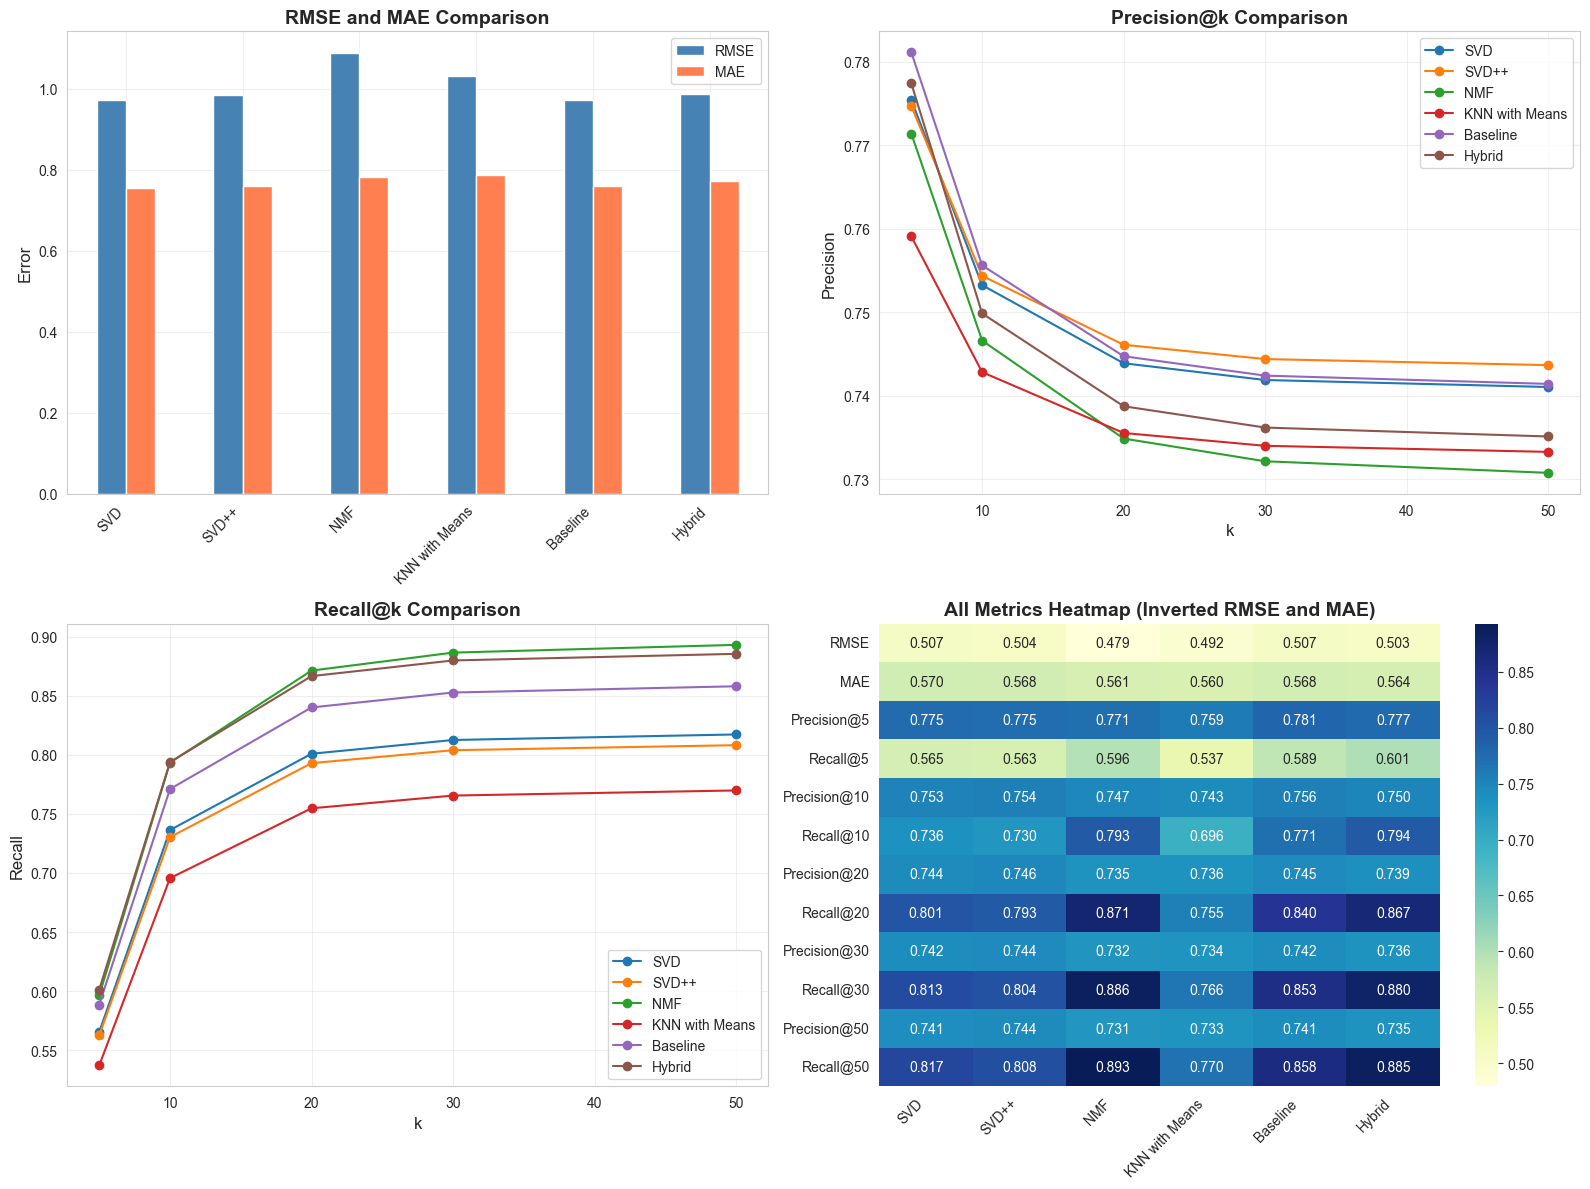

In [28]:
# create comparison plots
plot_model_comparison(all_results)

In [20]:
# print summary table
print("\n" + "="*100)
print("SUMMARY TABLE")
print("="*100)
summary_df = pd.DataFrame(all_results).T
print(summary_df.to_string())

# find best models for each metric
print("\n" + "="*100)
print("BEST MODELS BY METRIC")
print("="*100)
for col in summary_df.columns:
    if 'RMSE' in col or 'MAE' in col:
        best_model = summary_df[col].idxmin()
        best_value = summary_df[col].min()
    else:
        best_model = summary_df[col].idxmax()
        best_value = summary_df[col].max()
    print(f"{col:20s}: {best_model:20s} ({best_value:.4f})")


SUMMARY TABLE
                    RMSE       MAE  Precision@5  Recall@5  Precision@10  Recall@10  Precision@20  Recall@20  Precision@30  Recall@30  Precision@50  Recall@50
SVD             0.972780  0.754699     0.775458  0.565465      0.753275   0.736315      0.743918   0.800902      0.741908   0.812548      0.741070   0.817242
SVD++           0.983849  0.759937     0.774697  0.562549      0.754385   0.730335      0.746133   0.792950      0.744416   0.803902      0.743691   0.808163
NMF             1.087012  0.781094     0.771415  0.596403      0.746637   0.793444      0.734897   0.871295      0.732175   0.886500      0.730788   0.893071
KNN with Means  1.030522  0.785839     0.759106  0.537172      0.742855   0.695624      0.735564   0.754736      0.734027   0.765514      0.733300   0.769851
Baseline        0.973038  0.760343     0.781155  0.588669      0.755636   0.771033      0.744758   0.840097      0.742435   0.852727      0.741444   0.858019
Hybrid          0.986936  0.772309   

In [21]:
summary_df

,RMSE,MAE,Precision@5,Recall@5,Precision@10,Recall@10,Precision@20,Recall@20,Precision@30,Recall@30,Precision@50,Recall@50
SVD,0.972780,0.754699,0.775458,0.565465,0.753275,0.736315,0.743918,0.800902,0.741908,0.812548,0.741070,0.817242
SVD++,0.983849,0.759937,0.774697,0.562549,0.754385,0.730335,0.746133,0.792950,0.744416,0.803902,0.743691,0.808163
NMF,1.087012,0.781094,0.771415,0.596403,0.746637,0.793444,0.734897,0.871295,0.732175,0.886500,0.730788,0.893071
KNN with Means,1.030522,0.785839,0.759106,0.537172,0.742855,0.695624,0.735564,0.754736,0.734027,0.765514,0.733300,0.769851
Baseline,0.973038,0.760343,0.781155,0.588669,0.755636,0.771033,0.744758,0.840097,0.742435,0.852727,0.741444,0.858019
Hybrid,0.986936,0.772309,0.777432,0.601330,0.749883,0.793793,0.738767,0.866616,0.736214,0.879872,0.735144,0.885477


In [ ]:
# We can conclude that the hybrid model does not outperform the standard models like SVD and SVD++ in this evaluation. It performs the best in Recall@5 and Recall@10, but falls short in RMSE, MAE, and Precision@k metrics compared to SVD and SVD++. This suggests that while the hybrid model may be effective in capturing relevant recommendations for users (high recall), it may not be as accurate in predicting exact ratings (higher RMSE and MAE) or providing precise top-k recommendations (lower precision). Depending on the application, one might prefer SVD or SVD++ for overall accuracy, while the hybrid model could be favored for scenarios prioritizing recall.


In [22]:
summary_df.T

,SVD,SVD++,NMF,KNN with Means,Baseline,Hybrid
RMSE,0.972780,0.983849,1.087012,1.030522,0.973038,0.986936
MAE,0.754699,0.759937,0.781094,0.785839,0.760343,0.772309
Precision@5,0.775458,0.774697,0.771415,0.759106,0.781155,0.777432
Recall@5,0.565465,0.562549,0.596403,0.537172,0.588669,0.601330
Precision@10,0.753275,0.754385,0.746637,0.742855,0.755636,0.749883
Recall@10,0.736315,0.730335,0.793444,0.695624,0.771033,0.793793
Precision@20,0.743918,0.746133,0.734897,0.735564,0.744758,0.738767
Recall@20,0.800902,0.792950,0.871295,0.754736,0.840097,0.866616
Precision@30,0.741908,0.744416,0.732175,0.734027,0.742435,0.736214
Recall@30,0.812548,0.803902,0.886500,0.765514,0.852727,0.879872
